In [1]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy import stats
from tqdm import tqdm

from lib.data import conditions as cond
from lib.data import tables as tab
from lib.features import decomposition as de

In [2]:
np.random.seed(42)
plt.rc('svg', fonttype='none')

# Load data

In [3]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

Get the IDs of all cells that were added to the dataset on the first day.

In [4]:
day_one_cells = (
    session.query(tab.Cell)
    .join(tab.Cell.traces, tab.Trial)
    .filter(tab.Trial.day == 1)
    .subquery()
)

Get the average traces for non-catch trials of `day_one_cells` on days 1 and 7.

In [5]:
average_traces = []
days = []
cell_types = []
cell_ids = []

for res in tqdm(
    session.query(tab.TrialAverageTrace, tab.Mouse)
        .join(day_one_cells, tab.TrialAverageTrace.cell_id==day_one_cells.c.id)
        .join(tab.Mouse, day_one_cells.c.mouse_id==tab.Mouse.id)
        .filter(
            tab.TrialAverageTrace.day.in_([1, 7]), 
            tab.TrialAverageTrace.trial_kind == 'non_catch',
            tab.Mouse.cell_type != cond.CellType.som
        )
        .all()
):
    if not all(np.isnan(res[0].trace)):
        average_traces.append(res[0].trace)
        days.append(res[0].day)
        cell_ids.append(res[0].cell_id)
        cell_types.append(res[1].cell_type)

100%|██████████| 4016/4016 [00:00<00:00, 185880.72it/s]


In [6]:
average_traces = np.array([tr[:390] for tr in average_traces])
days = np.array(days)
cell_types = np.array(cell_types)
cell_ids = np.array(cell_ids)

In [7]:
average_traces.shape

(4003, 390)

In [8]:
days

array([1, 7, 1, ..., 7, 1, 7])

In [9]:
cell_types

array([CellType.vip, CellType.vip, CellType.vip, ..., CellType.vip,
       CellType.vip, CellType.vip], dtype=object)

In [10]:
np.sum((days == 1) & (cell_types == cond.CellType.vip))

483

The data I imported has 483 VIP cells on day 1. If I did everything right, that should match your analysis.

# Data preparation

PCA of trial average traces on day 7, using only cells from day 1.

I won't go into all the intuition behind the PCA here. Instead, please just take for granted that the end result represents the tuning of a particular cell to a particular part of the trial.

In [11]:
day7_pca = PCA(random_state=42)
day7_pca.fit(average_traces[days==7, :])
projections = day7_pca.transform(average_traces)

Text(0.5, 0, 'Component no.')

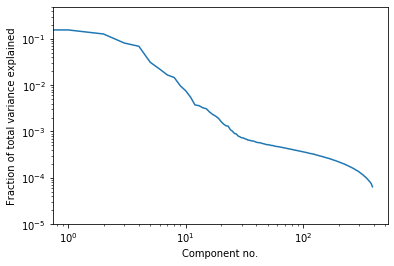

In [12]:
plt.loglog(day7_pca.explained_variance_ratio_)
plt.ylim(1e-5, 0.5)
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

Most of the variance in the data can be explained by only 30 temporal activity patterns.

In [13]:
day7_pca.components_.shape

(390, 390)

**Trial components**

Durations are in seconds.

In [14]:
trial_structure = de.TrialBasisFunctions(390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5)

Trial structure is represented in terms of a set of rectangular functions. Here's one of them.

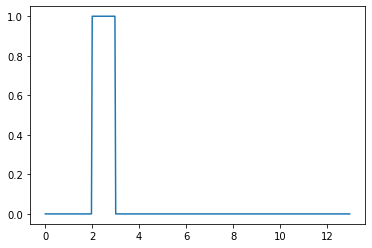

In [15]:
plt.plot(trial_structure.time, trial_structure.tone)

Which components are needed to capture trial structure? To find out, compute the cos similarity between a one-hot vector for each part of the trial and each component.

In [16]:
basis_similarities = {
    'tone': [
        de.cos_similarity(trial_structure.tone, day7_pca.components_[i, :]) 
        for i in range(390)
    ],
    'tone + delay': [
        de.cos_similarity(trial_structure.tone + trial_structure.delay, day7_pca.components_[i, :]) 
        for i in range(390)
    ],
    'reward': [
        de.cos_similarity(trial_structure.reward, day7_pca.components_[i, :]) 
        for i in range(390)
    ]
}

In [17]:
num_components = 50

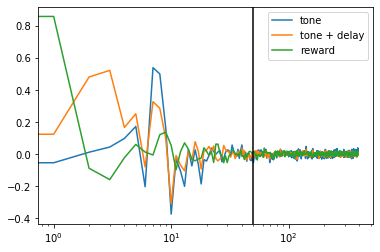

In [18]:
for trial_component in basis_similarities:
    plt.semilogx(basis_similarities[trial_component], label=trial_component)
plt.axvline(num_components, color='k')
plt.legend()

Project the trial structure onto the space spanned by the top few components.

In [19]:
basis_projections = {
    'tone': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.tone),
    'tone + delay': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.tone + trial_structure.delay),
    'delay': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.delay),
    'reward': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.reward),
}

Compute the tuning of each cell in terms of the similarity between the "idealized" representation of trial structure and what each cell actually does.

In [20]:
ideal_projection_similarities = {}

for trial_component in basis_projections.keys():
    ideal_projection_similarities[trial_component] = np.array([
        de.cos_similarity(projections[i, :num_components], basis_projections[trial_component])
        for i in range(projections.shape[0])
    ])

# Helper function for saving figures

In [21]:
def savefig(fig_basename, **kwargs):
    plt.savefig(fig_basename + '.png', **kwargs)
    plt.savefig(fig_basename + '.svg', **kwargs)

# Illustrate how decomposition works

In [22]:
inds_grouped_by_cell_type = []
for cell_type in [cond.CellType.pyr, cond.CellType.vip, cond.CellType.pv, cond.CellType.som]:
    inds_grouped_by_cell_type.append(np.where(cell_types[days==7] == cell_type)[0])
    
inds_grouped_by_cell_type = np.concatenate(inds_grouped_by_cell_type)
inds_grouped_by_cell_type

array([ 505,  506,  507, ..., 1922, 1923, 1924])

In [23]:
FRAME_RATE = 30.0
BASELINE_DURATION = 2.
time_vec = np.arange(390) / FRAME_RATE - BASELINE_DURATION

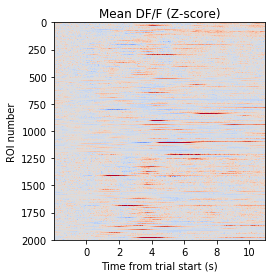

In [38]:
plt.subplot(111)
plt.title('Mean DF/F (Z-score)')
plt.ylabel('ROI number')
plt.xlabel('Time from trial start (s)')
plt.imshow(average_traces[inds_grouped_by_cell_type, :], aspect=0.2, cmap=plt.cm.coolwarm, vmin=-2, vmax=2)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))

savefig('../img/graphics/mean_dff', dpi=600, bbox_inches='tight')

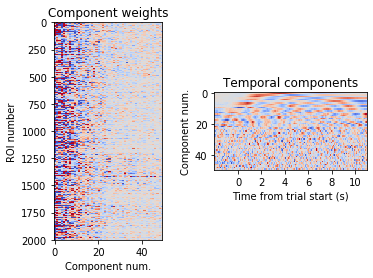

In [37]:
plt.subplot(121)
plt.title('Component weights')
plt.ylabel('ROI number')
plt.xlabel('Component num.')
plt.imshow(
    day7_pca.transform(average_traces[inds_grouped_by_cell_type, :])[:, :num_components], aspect=0.05, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1
)

plt.subplot(122)
plt.title('Temporal components')
plt.xlabel('Time from trial start (s)')
plt.ylabel('Component num.')
plt.imshow(day7_pca.components_[:num_components, :], aspect=4, cmap=plt.cm.coolwarm, vmin=-0.15, vmax=0.15)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))

savefig('../img/graphics/decomposed_dff', dpi=600, bbox_inches='tight')

In [33]:
reconstructed = day7_pca.transform(average_traces)[:, :num_components] @ day7_pca.components_[:num_components, :]

In [34]:
strongly_responding_cells = np.flip(np.argsort(average_traces[inds_grouped_by_cell_type, :].mean(axis=1)))

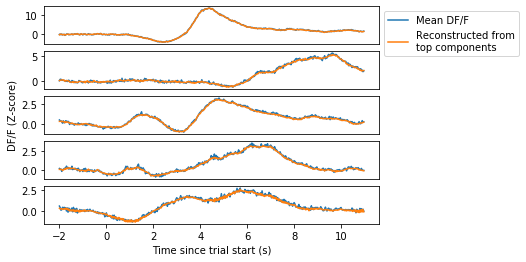

In [36]:
for i, ind in enumerate(inds_grouped_by_cell_type[strongly_responding_cells[:25:5]]):
    plt.subplot(5, 1, i+1)
    plt.plot(time_vec, average_traces[ind, :], label='Mean DF/F')
    plt.plot(time_vec, reconstructed[ind, :], label='Reconstructed from\ntop components')
    if i == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    if i == 2:
        plt.ylabel('DF/F (Z-score)')
    if i <4 :
        plt.xticks([])
    else:
        plt.xlabel('Time since trial start (s)')
        
savefig('../img/graphics/reconstruction', dpi=600, bbox_inches='tight')

# Tuning by trial stage, cell-type, and day

Figures!!!

In [35]:
def patch_violinplot():
    from matplotlib.collections import PolyCollection
    ax = plt.gca()
    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for violin in violins:
        violin.set_linewidth(0.5)

In [36]:
CELLTYPE_ORDER = [cond.CellType.pyr, cond.CellType.vip, cond.CellType.pv]
CELLTYPE_LABELS = ['PN', 'VIP', 'PV']

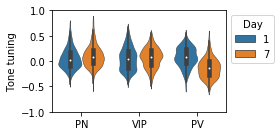

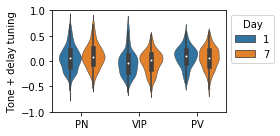

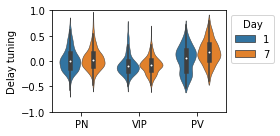

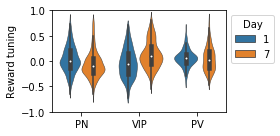

In [37]:
for key in ideal_projection_similarities:
    plt.figure(figsize=(4, 2))
    ax = plt.subplot(111)

    sns.violinplot(
        cell_types, ideal_projection_similarities[key], days, 
        order=CELLTYPE_ORDER,
        cut=1, ax=ax
    )
    plt.ylim(-1, 1)
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.gca().set_xticklabels(CELLTYPE_LABELS)
    if key == 'tone + delay':
        plt.ylabel(f'Tone tuning')
    else:
        plt.ylabel(f'{key.capitalize()} tuning')

    plt.legend(loc='upper left', title='Day', bbox_to_anchor=(1, 1))
    
    patch_violinplot()

    plt.tight_layout()
    
    savefig('../img/response_violins/{}'.format(key), dpi=600, bbox_inches='tight')
    plt.show()

The y-axis ranges from -1 to 1 and can be **interpreted similarly to a correlation coefficient** between the trial-averaged fluorescence for a given cell and the trial component of interest. Values close to 1 indicate that the cell is activated during that part of the trial, values close to -1 indicate that it is inhibited, and values close to 0 indicate that the flurescence doesn't change from baseline.

These violin plots show the distribution of tuning across cells stratified by cell type, day, and trial component. Think of these like smoothed vertical histograms, where the wider parts of the violin indicate a greater proportion of cells and vice-versa. The overlaid boxplots show the range from the 25th to the 75th percentile (thick black bar; half of cells lie in this range), the median (point), and the range excluding outliers (whiskers; if you want the gory details, this is the range of cells within 1.5 times the interquartile range of the median).

### Observations

To me, the most visually obvious differences between tuning on days 1 and 7 are:
- Pyramidal neurons become more inhibited by reward
- VIP neurons become more activated by reward
- PV cells become more inhibited by tone and activated by delay
    - These effects seem to cancel out when tone and delay are pooled together, so this might not show up in your analysis.

## Closer look at changes in tuning

If we want to know whether tuning is changing from day 1 to day 7, we should look at `day_7_tuning - day_1_tuning` and do some statistics.

In [38]:
def similarity_change_by_cell_type(trial_component):
    df = pd.DataFrame(
        {
            'id': cell_ids,
            'cell_type': cell_types, 
            'day': days, 
            'similarity': ideal_projection_similarities[trial_component]
        },
    )
    piv = df.pivot(index='id', columns='day', values='similarity')
    joined = df.drop_duplicates('id', 'first').set_index('id').join(piv, how='inner')
    joined['similarity_change'] = joined[7] - joined[1]
    similarity_change_df = joined.loc[:, ['cell_type', 'similarity_change']]
    
    return similarity_change_df

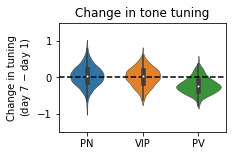

Bonferroni-corrected Wilcoxon p=2.60430988525722e-07 for pyr *
Bonferroni-corrected Wilcoxon p=0.22501727759854354 for vip 
Bonferroni-corrected Wilcoxon p=1.457239087261845e-34 for pv *


/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


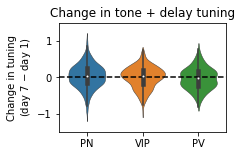

Bonferroni-corrected Wilcoxon p=2.577169135640873e-05 for pyr *
Bonferroni-corrected Wilcoxon p=0.40354416857237363 for vip 
Bonferroni-corrected Wilcoxon p=0.5033956761690502 for pv 


/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


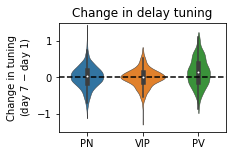

Bonferroni-corrected Wilcoxon p=0.1499012162077182 for pyr 
Bonferroni-corrected Wilcoxon p=2.8908587830587766 for vip 
Bonferroni-corrected Wilcoxon p=2.636411907461191e-08 for pv *


/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


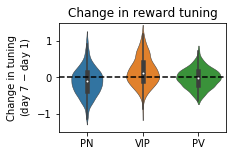

Bonferroni-corrected Wilcoxon p=1.569532414634627e-19 for pyr *
Bonferroni-corrected Wilcoxon p=2.371370200563653e-15 for vip *
Bonferroni-corrected Wilcoxon p=1.7120046955491444 for pv 


/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


In [39]:
for trial_component in ideal_projection_similarities:
    similarity_change = similarity_change_by_cell_type(trial_component)
    
    plt.figure(figsize=(3, 2))
    
    sns.violinplot(
        'cell_type', 'similarity_change', data=similarity_change,
        cut=1, order=CELLTYPE_ORDER
    )
    plt.gca().set_xticklabels(CELLTYPE_LABELS)
    plt.axhline(0, color='k', ls='--')
    patch_violinplot()
    
    plt.ylim(-1.5, 1.5)
    plt.ylabel('Change in tuning\n(day 7 $-$ day 1)')
    plt.xlabel('')
    plt.title(f'Change in {trial_component} tuning')
    
    savefig('../img/response_violins/{}_change'.format(trial_component), dpi=600, bbox_inches='tight')
    
    plt.show()
    
    for cell_type in CELLTYPE_ORDER:
        w, p = stats.wilcoxon(
            similarity_change.loc[similarity_change['cell_type'] == cell_type, 'similarity_change']
        )
        print(f'Bonferroni-corrected Wilcoxon p={p * 4} for {cell_type} {"*" if p * 4 < 0.05 else ""}')

The Wilcoxon test is a non-parametric equivalent to a paired t-test. p-values are corrected for four comparisons, one for each cell type. Bonferroni corrected p < 0.05 indicates that the **median change in tuning is not zero**. Median change in tuning > 0 means that the cells are activated more strongly on day 7, and change in tuning < 0 means that the cells are inhibited more strongly on day 7. Note that stars `*` just indicate p < 0.05, see the p-value for the actual significance level.

### Observations

- Pyramidal neurons become activated by tone + delay, which is driven by an increase in activation during the tone period
- Pyramidal and VIP neurons show opposite changes in the response to reward
    - Pyramidal neurons become more inhibited by reward
    - VIP neurons become more activated by reward
- PV and SOM neurons become inhibited by tone and activated by delay, but when the tone and delay periods are pooled together these effects are lost

### Note about interpretation of reward results

The responses during the reward period are presumably due to a combination of factors, including
- reward expectation (aka reward prediction)
- reward prediction error
- behaviours involved in consuming the reward
- leftover activity from other parts of the trial
- background noise

The statistics above show that some apparent changes in tuning are not due to background noise, but we can't know which of the other factors might be changing using this analysis.

# 2nd order tuning properties

What relationships are there between tuning to tone + delay and reward?

## How do changes in tuning depend on initial tuning?

We know that cells change their tuning to tone + delay and reward over time. But how do these changes depend on the initial tuning? The following quiver plots should give us an idea. 

In [27]:
def learning_quiver(x, y, units, first_timestep, bins=20):
    x = np.asarray(x)
    y = np.asarray(y)
    units = np.asarray(units)
    timestep_mask = np.asarray(first_timestep)
    assert len(x) == len(y)
    assert len(x) == len(units)
    assert len(x) == len(first_timestep)
    
    x_bin_edges = np.linspace(x.min(), x.max(), bins + 1)
    y_bin_edges = np.linspace(y.min(), y.max(), bins + 1)
    
    x_starts = []
    y_starts = []
    x_ends = []
    y_ends = []
    count = []
    for i in range(bins):
        for j in range(bins):
            start_mask = (
                (x >= x_bin_edges[i]) 
                & (x < x_bin_edges[i + 1])
                & (y >= y_bin_edges[j])
                & (y < y_bin_edges[j + 1])
                & first_timestep
            )
            count.append(np.sum(start_mask))
            units_in_start_bin = units[start_mask]
            end_mask = [
                (uid in units_in_start_bin) and not timestep
                for timestep, uid in zip(first_timestep, units) 
            ]
            x_starts.append(x[start_mask].mean())
            y_starts.append(y[start_mask].mean())
            x_ends.append(x[end_mask].mean() - x_starts[-1])
            y_ends.append(y[end_mask].mean() - y_starts[-1])
            
    plt.quiver(
        x_starts, y_starts, x_ends, y_ends, count, angles='xy', scale_units='xy', 
        width=0.01,
        scale=None
    )

In [28]:
def learning_quiver_by_condition(cell_type, x_component, y_component, flip_time=False):
    mask = cell_types == cell_type
    if not flip_time:
        first_timestep_mask = days[mask] == 1
    else:
        first_timestep_mask = days[mask] == 7
    learning_quiver(
        x=ideal_projection_similarities[x_component][mask], 
        y=ideal_projection_similarities[y_component][mask],
        units=cell_ids[mask],
        first_timestep=first_timestep_mask,
        bins=5
    )

<ipython-input-27-6028afb940b2>:33: RuntimeWarning: Mean of empty slice.
  x_starts.append(x[start_mask].mean())
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-27-6028afb940b2>:34: RuntimeWarning: Mean of empty slice.
  y_starts.append(y[start_mask].mean())
<ipython-input-27-6028afb940b2>:35: RuntimeWarning: Mean of empty slice.
  x_ends.append(x[end_mask].mean() - x_starts[-1])
<ipython-input-27-6028afb940b2>:36: RuntimeWarning: Mean of empty slice.
  y_ends.append(y[end_mask].mean() - y_starts[-1])
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minl

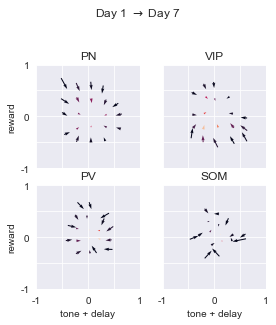

In [29]:
sns.set_style('darkgrid')

plt.figure(figsize=(4, 4.5))
plt.suptitle(r'Day 1 $\rightarrow$ Day 7')

for i, (celltype, ctlabel) in enumerate(zip(CELLTYPE_ORDER, CELLTYPE_LABELS)):
    
    plt.subplot(2, 2, i+1)
    
    plt.title(ctlabel)
    plt.gca().set_aspect(1)
    learning_quiver_by_condition(
        celltype, 'tone + delay', 'reward'
    )
    
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    if i > 1:
        plt.xlabel('tone + delay')
        plt.gca().set_xticklabels(['-1', '', '0', '', '1'])
    else:
        plt.gca().set_xticklabels([])
        
    if i %2 == 0:
        plt.ylabel('reward')
        plt.gca().set_yticklabels(['-1', '', '0', '', '1'])
    else:
        plt.gca().set_yticklabels([])
        
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    

plt.tight_layout()
plt.subplots_adjust(top=0.8)

plt.savefig('../img/quiver/all_celltypes_not_to_scale.png'.format(celltype), dpi=600)

plt.show()


Arrows are rooted at the average initial tuning for a group of cells (i.e., tuning on day 1) and point toward the final tuning (day 7). Longer arrows indicate a bigger change in tuning. Lighter arrows indicate tuning bins with more cells.

### Observations:

The arrows mostly point towards the center, which means that strongly tuned cells tend to lose their tuning, no matter what they were initially tuned to.

#### Pyramidal neurons
In pyramidal neurons, there seems to be some movement towards the lower right, **consistent with the statistics on the violin plots above** that show decreasing reward tuning and increasing tone + delay tuning.

#### VIP neurons
VIP neurons seem to be going towards the upper left. This is **partly consistent with the stats on the violin plots** which show increasing reward tuning, but no significant change in tone + delay tuning. Visually, the change in tone + delay tuning seems to be strongest in a small number of cells with initially strong positive tuning to tone + delay and strong negative tuning to reward (lower right quadrant), and maybe this gets washed out when the whole population of cells is considered.

#### PV and SOM
There aren't as many PV or SOM cells in the dataset, so the arrows are pretty noisy. I don't think the apparent patterns here are worth expending much brain juice on.

## Note: everything below here is out of date, but potentially useful

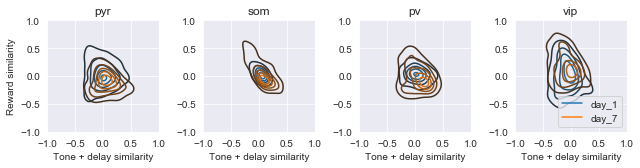

In [28]:
def mask(cell_type, first_day, day):
    mask = (
        (grand_fluo.get_meta_attr('cell_type') == cell_type) 
        & (grand_fluo.get_meta_attr('first_day').apply(hash) == first_day)
        & (grand_fluo.get_meta_attr('day').apply(hash) == day)
    )
    return mask

days_to_plot = {
    'left': min(cond.DAYS),
    'right': max(cond.DAYS)
}
gridsize=(7)

plt.figure(figsize=(9, 3))

for i, cell_type in enumerate(cond.CellType):

    plt.subplot(1, len(cond.CellType), i+1)
    plt.title(cell_type)
    plt.gca().set_aspect(1)
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    sns.kdeplot(
        ideal_projection_similarities['tone + delay'][mask(cell_type, min(cond.DAYS), days_to_plot['left'])],
        ideal_projection_similarities['reward'][mask(cell_type, min(cond.DAYS), days_to_plot['left'])],
        n_levels=5,
        label=str(days_to_plot['left'])
    )
    sns.kdeplot(
        ideal_projection_similarities['tone + delay'][mask(cell_type, min(cond.DAYS), days_to_plot['right'])],
        ideal_projection_similarities['reward'][mask(cell_type, min(cond.DAYS), days_to_plot['right'])],
        n_levels=5,
        label=str(days_to_plot['right'])
    )
    plt.xlabel('Tone + delay similarity')
    if i == 0:
        plt.ylabel('Reward similarity')
    plt.xticks([-1, -0.5, 0, 0.5, 1])

plt.legend(loc='lower right')
    
plt.tight_layout()

plt.savefig('../img/joint_response_patterns/all_cells.png'.format(cell_type), dpi=290)

This plot is out of date, but it shows the relationship between the tuning to reward and tone + delay for each cell type at the start and the end of the experiment. This has the same information as the quiver plots, except that here it isn't clear what's driving these changes.

In [29]:
def mask(first_day, days):
    mask = (
        (grand_fluo.get_meta_attr('first_day').apply(hash) == first_day)
        & np.isin(grand_fluo.get_meta_attr('day').apply(hash), days)
    )
    return mask

In [30]:
pivoted = (
    df
    .loc[mask(min(cond.DAYS), cond.DAYS), :]
    .pivot(index='cell_uid', columns='day', values=['reward', 'tone + delay', 'cell_type'])
)

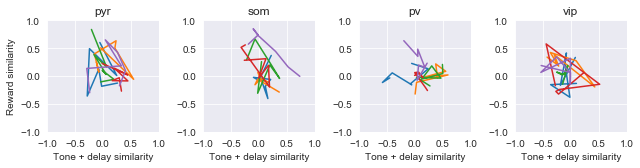

In [31]:
plt.figure(figsize=(9, 3))

for i, cell_type in enumerate(cond.CellType):

    tmp = pivoted.loc[pivoted['cell_type'][cond.Day(1)] == cell_type, ['reward', 'tone + delay']]
    probs = np.linalg.norm(
        np.array([tmp['reward'][cond.Day(7)], tmp['tone + delay'][cond.Day(7)]]).astype(np.float64), 
        axis=0
    )
    rows = np.random.choice(np.arange(tmp.shape[0]), size=5, replace=False, p=np.nan_to_num(probs) / np.nansum(probs))

    plt.subplot(1, len(cond.CellType), i+1)
    plt.title(cell_type)
    plt.gca().set_aspect(1)
    
    plt.plot(tmp['tone + delay'].iloc[rows, :].to_numpy().T, tmp['reward'].iloc[rows, :].to_numpy().T)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    
    plt.xlabel('Tone + delay similarity')
    if i == 0:
        plt.ylabel('Reward similarity')
    
plt.tight_layout()
plt.savefig('../img/joint_response_patterns/sample_trajectories.png', dpi=600)

This plot is out of date, but it illustrates just how much the tuning changes from one day to the next. Each line is one cell, and each vertex is one day. If the tuning changed gradually over the course of several days, we'd expect smooth lines that follow a clear path.